In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
import datetime
import scipy.stats
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv('combined_15min.csv')
df = df.drop_duplicates()
df

,date,temp_ambient,temp_system,temp_atmos_10,radW/m2,netW/m2
0,2022-01-01 06:00:00+00:00,5.401000,26.862333,3.46,82.56,-3.54
2,2022-01-01 06:15:00+00:00,5.316000,26.633667,3.35,82.19,-3.25
4,2022-01-01 06:30:00+00:00,5.273000,26.713000,3.23,81.91,-3.71
6,2022-01-01 06:45:00+00:00,5.159000,26.379333,3.14,83.19,-2.99
8,2022-01-01 07:00:00+00:00,5.136667,26.421333,3.09,83.43,-3.69
...,...,...,...,...,...,...
9415,2022-02-24 18:30:00+00:00,-1.372000,20.299000,-3.68,143.91,72.75
9416,2022-02-24 18:45:00+00:00,-1.618000,19.839000,-3.71,122.61,59.41
9417,2022-02-24 19:00:00+00:00,-1.686333,19.627000,-3.75,106.34,48.64
9418,2022-02-24 19:15:00+00:00,-1.822000,19.383000,-3.87,129.75,64.51


In [3]:
#Trying to get month and hour from date object to use as features
#2022-XX-01 XX:00:00+00:00
df.date[0]
datem = datetime.datetime.strptime(df.date[0], "%Y-%m-%d %H:%M:%S+00:00")
print(datem.month)
print(datem.hour)

1
6


In [4]:
months = []
hours = []
for date in df.date:
    datem = datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S+00:00")
    months.append(datem.month)
    hours.append(datem.hour)
df['month'] = months
df['hour'] = hours
#Use the month and hour as features for the machine learning model
#features are what you use to evaluate / input in system
# add z-score as a feature
df['z_score'] = (df['temp_ambient'] - df['temp_ambient'].mean()) / df['temp_ambient'].std()
display(df)
#Which variable am I trying to predict? = temp_atmos_10 using temp_ambient and temp_system
#radW/m2 and netW/m2 can be used for training, but won't be used for inference
#time of day is another thing I can use too
# add slope as a feature!! 

,date,temp_ambient,temp_system,temp_atmos_10,radW/m2,netW/m2,month,hour,z_score
0,2022-01-01 06:00:00+00:00,5.401000,26.862333,3.46,82.56,-3.54,1,6,1.384701
2,2022-01-01 06:15:00+00:00,5.316000,26.633667,3.35,82.19,-3.25,1,6,1.371003
4,2022-01-01 06:30:00+00:00,5.273000,26.713000,3.23,81.91,-3.71,1,6,1.364074
6,2022-01-01 06:45:00+00:00,5.159000,26.379333,3.14,83.19,-2.99,1,6,1.345703
8,2022-01-01 07:00:00+00:00,5.136667,26.421333,3.09,83.43,-3.69,1,7,1.342104
...,...,...,...,...,...,...,...,...,...
9415,2022-02-24 18:30:00+00:00,-1.372000,20.299000,-3.68,143.91,72.75,2,18,0.293250
9416,2022-02-24 18:45:00+00:00,-1.618000,19.839000,-3.71,122.61,59.41,2,18,0.253608
9417,2022-02-24 19:00:00+00:00,-1.686333,19.627000,-3.75,106.34,48.64,2,19,0.242596
9418,2022-02-24 19:15:00+00:00,-1.822000,19.383000,-3.87,129.75,64.51,2,19,0.220734


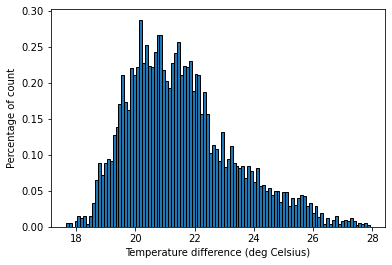

<Figure size 1000x800 with 0 Axes>

In [5]:
#df.temp_system
Sys_amb = pd.Series(df.temp_system - df.temp_ambient) #system - ambient
#104 bins
plt.hist(Sys_amb, density=True, stacked=True,bins=104, edgecolor="k")
plt.xlabel("Temperature difference (deg Celsius)")
plt.ylabel("Percentage of count")
plt.figure(figsize=(10,8), dpi=100)
plt.show()

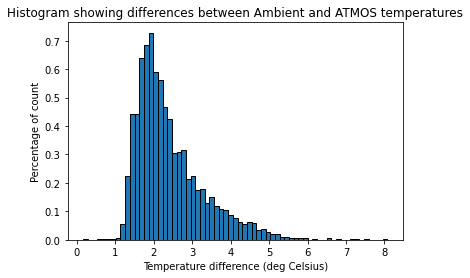

<Figure size 1000x800 with 0 Axes>

In [6]:
Amb_atmos = pd.Series(df.temp_ambient - df.temp_atmos_10)
plt.hist(Amb_atmos, density=True, stacked=True,bins=65,edgecolor="k")
plt.xlabel("Temperature difference (deg Celsius)")
plt.ylabel("Percentage of count")
plt.title("Histogram showing differences between Ambient and ATMOS temperatures")
plt.figure(figsize=(10,8), dpi=100)
plt.show()

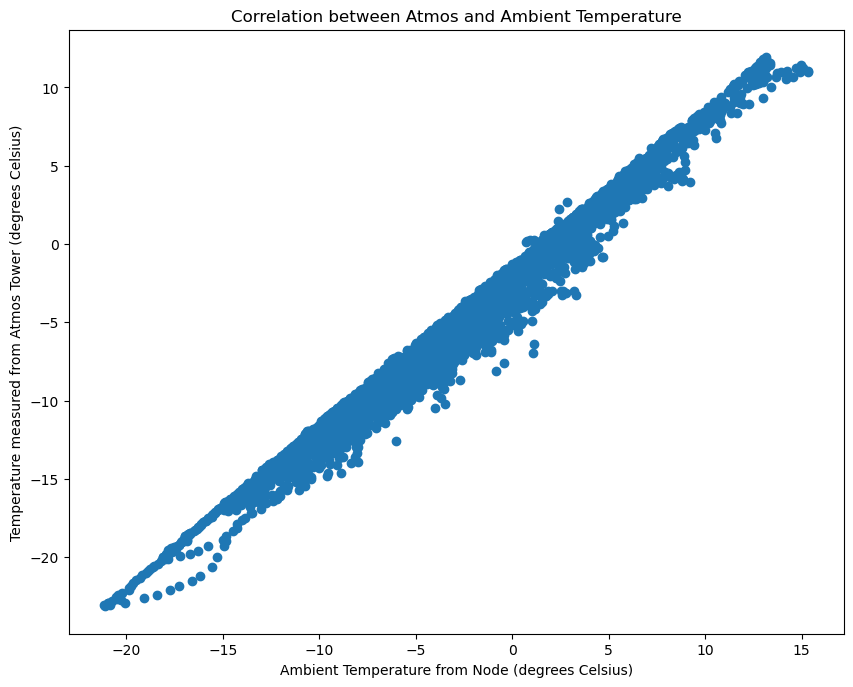

In [26]:
#x is temp_atmos_10
#y is temp_ambient
#in order to make scatter plot to show correlation
#x is atmos tower, y is ambient temperature
plt.scatter(df.temp_ambient, df.temp_atmos_10)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.xlabel('Ambient Temperature from Node (degrees Celsius)')
plt.ylabel('Temperature measured from Atmos Tower (degrees Celsius)')
plt.title("Correlation between Atmos and Ambient Temperature")
plt.show()

The graph above is a positive slope, which means that there is a positive correlation between Ambient Temperature and the Atmos Tower readings.

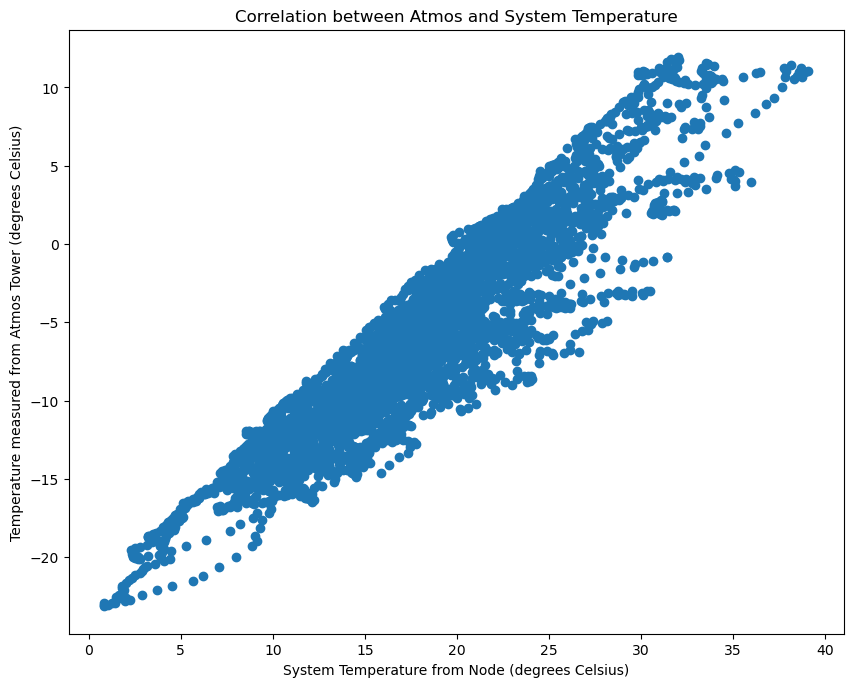

In [28]:
plt.scatter(df.temp_system, df.temp_atmos_10)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.xlabel('System Temperature from Node (degrees Celsius)')
plt.ylabel('Temperature measured from Atmos Tower (degrees Celsius)')
plt.title("Correlation between Atmos and System Temperature")
plt.show()

In [8]:
#Building a linear regression machine learning model
#includes feature columns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
feature_columns = ['temp_ambient', 'temp_system', 'radW/m2', 'netW/m2', 'month', 'hour', 'z_score']
#feature_columns = ['temp_ambient', 'temp_system', 'month', 'hour', 'z_score']
X = df[feature_columns]
y = df['temp_atmos_10']
#Assign variables to capture the train and test output
X_train, X_test, y_train, y_test = train_test_split(X, y)
#split X and y into training and testing sets
linreg = LinearRegression()
#fit model to training data
linreg.fit(X_train, y_train)
print("y-intercept:", linreg.intercept_)
print("beta coefficients:", linreg.coef_)
y_pred = linreg.predict(X_test)
#Professor recommended the RMSE (root mean squared error) metric
print("accuracy with RMSE metric:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

y-intercept: 3.7944507019788043
beta coefficients: [ 1.23186814 -0.26656444 -0.00271473  0.00136762 -0.08286093 -0.00881424
  0.19851227]
accuracy with RMSE metric: 0.49127996362025633


In [29]:
#This plot function works in tandem with the model below:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [31]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                 optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [21]:
#Building a linear regression model, based on a different tutorial
#split the dataset into a training set and a test set
df2 = df[['temp_ambient', 'temp_system', 'temp_atmos_10', 'radW/m2', 'netW/m2', 'month', 'hour', 'z_score']]
train_dataset = df2.sample(frac=0.8, random_state=0)
test_dataset = df2.drop(train_dataset.index)
#split features from label
train_features = train_dataset.copy()
test_features = test_dataset.copy()
#separate target value from the features
train_labels = train_features.pop('temp_atmos_10')
test_labels = test_features.pop('temp_atmos_10')
train_features

,temp_ambient,temp_system,radW/m2,netW/m2,month,hour,z_score
5662,2.738667,27.797333,553.71,31.82,1,18,0.955673
8564,5.798667,28.540333,284.97,87.27,2,21,1.448784
5114,1.428667,22.355667,191.25,-11.80,1,21,0.744570
3954,-0.835000,22.695333,407.30,74.60,1,20,0.379786
8664,12.123000,30.105667,36.19,7.04,2,22,2.467933
...,...,...,...,...,...,...,...
6966,-7.071000,13.213667,47.02,-19.21,2,13,-0.625129
3182,-1.353000,19.630333,164.95,25.46,1,20,0.296312
7454,4.063333,23.953667,40.05,-39.97,2,2,1.169139
7726,1.088333,23.202000,41.98,-12.60,2,12,0.689726


In [22]:
#add feature normalization to the model
normalizer = tf.keras.layers.Normalization(axis=-1)
#fit state of preprocessing layer to the data
normalizer.adapt(np.array(train_features))

In [23]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
#run a prediction on a small batch of inputs
linear_model.predict(train_features[:10])
linear_model.layers[1].kernel
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

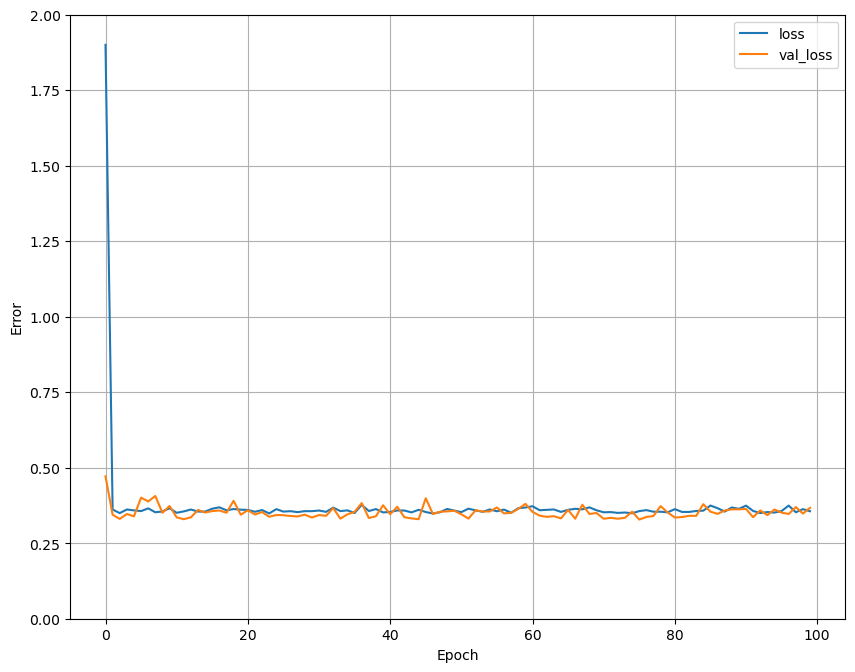

In [24]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    #Calculate validation results on 20% of the training data
    validation_split = 0.20)
plot_loss(history)

In [30]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
test_features, test_labels, verbose=0)

In [33]:
#making a deep neural network model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 7)                 15        
_________________________________________________________________
dense_3 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________


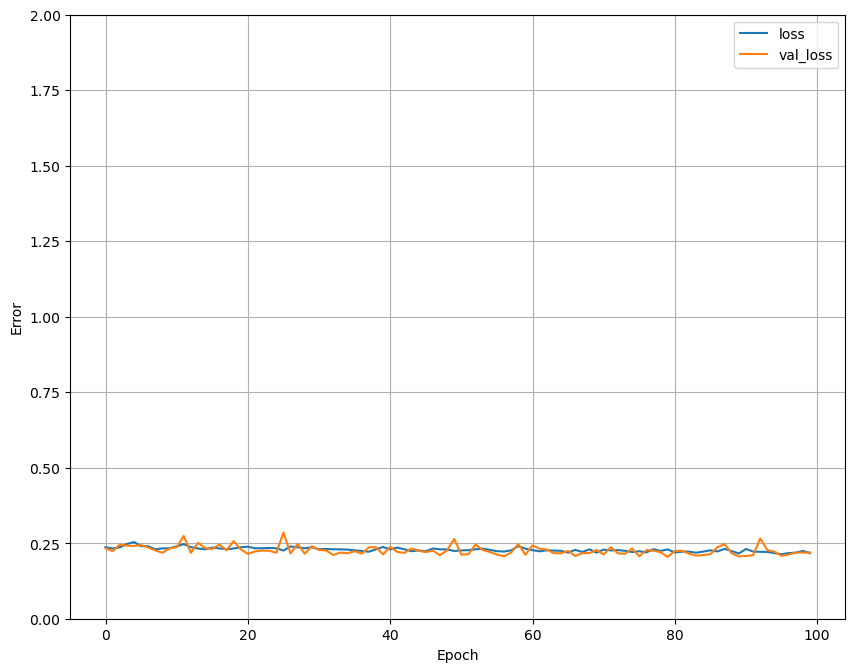

In [35]:
history_dnn = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(history_dnn)

In [36]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [39]:
pd.DataFrame(test_results, index=['Mean Absolute Error (Ambient Temp)']).T

,Mean Absolute Error (Ambient Temp)
linear_model,0.370005
dnn_model,0.247640


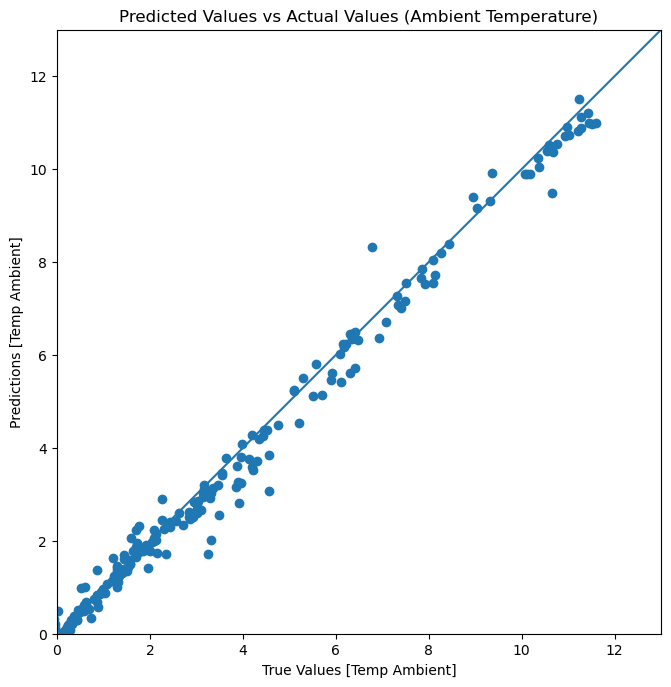

In [49]:
test_predictions = dnn_model.predict(test_features).flatten()
a = plt.axes(aspect = 'equal')
plt.scatter(test_labels, test_predictions)
plt.title("Predicted Values vs Actual Values (Ambient Temperature)")
plt.xlabel("True Values [Temp Ambient]")
plt.ylabel("Predictions [Temp Ambient]")
lims = [0, 13]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

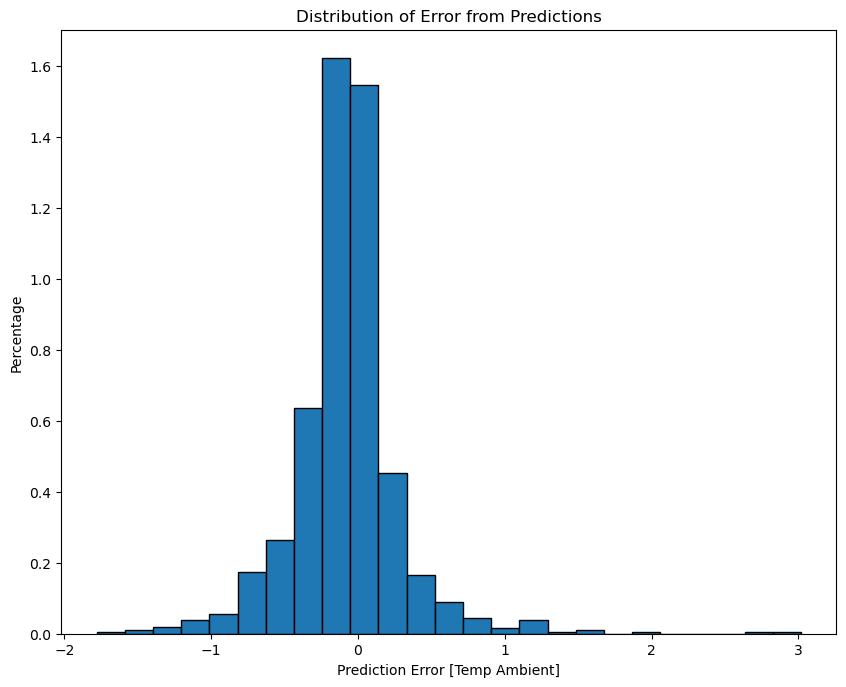

In [48]:
error = test_predictions - test_labels
plt.hist(error, density=True, stacked=True, bins=25, edgecolor="k")
plt.xlabel("Prediction Error [Temp Ambient]")
plt.title("Distribution of Error from Predictions")
_ = plt.ylabel("Percentage")

In [44]:
#Difference between the predictions 
print(error)

0      -0.260775
14     -0.033352
42     -0.095743
48     -0.157192
50     -0.309822
          ...   
9403   -0.064244
9405    0.046260
9406    0.338138
9411    0.007011
9417    0.128301
Name: temp_atmos_10, Length: 1047, dtype: float64
